In [1]:
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa

from models.VGG16_with_flex_v5 import *

use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

if __name__ == "__main__":
    # instantiate a model
    model = VGG16().to(device)
    preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fmodel = PyTorchModel(model, bounds=(-2.117, 2.64), preprocessing=preprocessing)
    
    # Load the pretrained model
    state = torch.load('./models/VGG16-flex-v5-block1-model_150_90.pth')
    model.load_state_dict(state['model']) 
    model.eval()

    # get data and test the model
    # wrapping the tensors with ep.astensors is optional, but it allows
    # us to work with EagerPy tensors in the following
    images, labels = ep.astensors(*samples(fmodel, dataset="cifar10", batchsize=20, shape=(32, 32), bounds=(-1, 1)))
    print(accuracy(fmodel, images, labels))

    # apply the attack
    attack = fa.boundary_attack.BoundaryAttack(
    steps=25000,
    )
    
    epsilons = [0.0, 0.03, 0.1, 0.3]
    advs, _, success = attack(fmodel, images, labels, epsilons=epsilons)

    # calculate and report the robust accuracy
    robust_accuracy = 1 - success.float32().mean(axis=-1)
    for eps, acc in zip(epsilons, robust_accuracy):
        print(eps, acc.item())

/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


0.949999988079071
0.0 0.949999988079071
0.03 0.8500000238418579
0.1 0.75
0.3 0.699999988079071


In [6]:
x = [0.949999988079071, 0.949999988079071, 0.8500000238418579, 0.75, 0.699999988079071]
y = [0.9000000357627869, 0.8999999761581421, 0.8500000238418579, 0.800000011920929, 0.6000000238418579]

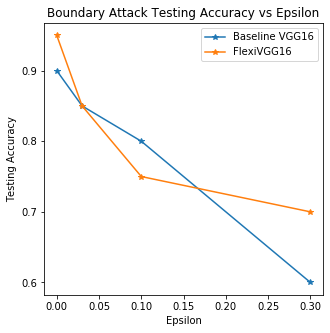

In [11]:
import matplotlib.pyplot as plt
import numpy as np

epsilons = [0.0, 0.03, 0.1, 0.3]
accuracies1 = [0.9, 0.85, 0.80, 0.60]
accuracies2 = [0.95, 0.85, 0.75, 0.7] # trained over 150 epochs
#accuracies3 = [0.8859, 0.5146, 0.4343, 0.4052, 0.3878, 0.3729, 0.3536] # trained over 100 epochs
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies1, "*-", label = "Baseline VGG16")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.plot(epsilons, accuracies2, "*-", label = "FlexiVGG16")
plt.xticks(np.arange(0, .35, step=0.05))
#plt.plot(epsilons, accuracies3, "*-", label = "FlexiVGG16_batch_indep_100epochs")
plt.title("Boundary Attack Testing Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Testing Accuracy")
plt.legend()
#plt.savefig('./figures/fgsm_testing_results.png', format='png')
plt.show()